# 0.) Load libraries and get ready to load data

In [1]:
# Load libraries
%matplotlib inline
import cv2
import IPython.display as disp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rand
import re
import seaborn as sns
import sys

from itertools import product

from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir
from os.path import isdir, isfile, join as osjoin
from random import shuffle

# Setup datapaths
base_path = './datasets/IntelImageClassification/'

pred_path = 'seg_pred/seg_pred/'
test_path = 'seg_test/seg_test/'
train_path = 'seg_train/seg_train/'

# Func. to make full paths from base_path
def route(*args):
    full_path = base_path
    for a in args:
        full_path = osjoin(full_path, a)
        
    return full_path

# Make sure paths exist
if isdir(base_path):
    msg = "Couldn't find the dataset path {}. Please check that it is correct."
    
    if not isdir(route(pred_path)):
        print(msg.format(route(pred_path)))
    if not isdir(route(test_path)):
        print(msg.format(route(train_path)))
    if not isdir(route(train_path)):
        print(msg.format(route(train_path)))
else:
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")

# 1.) Load Images

In [2]:
# Generate labels
labels = []
for folder in listdir(route(train_path)):
    assert(isdir(route(test_path, folder))) # Sanity check
    labels.append(folder)
    
# Func. to eliminate code reuse in loading images
# (adapted from Assignment document)
def load_img(path, x, y):
    for f in sorted([_ for _ in listdir(path) if _.lower().endswith('.jpg')]):
        x += [cv2.resize(cv2.imread(osjoin(path,f)), IMGSIZE)]
        y += [labels.index(label)]
        
    return x, y
        
# Load images (adapted from Assignment document)
IMGSIZE = (128, 128)
x_tr, y_tr, x_ts, y_ts = [], [], [], []
for label in labels:
    tr_path = route(train_path, label)
    x_tr, y_tr = load_img(tr_path, x_tr, y_tr)
      
    ts_path = route(test_path, label)
    x_ts, y_ts = load_img(ts_path, x_ts, y_ts)

In [3]:
# Check the number of channels
channels = len(x_tr[0][0][0])

# Since these are coloured images we expect 3
disp.display_markdown(f"__Number of Channels:__ {channels}", raw=True)

assert(channels == 3)

__Number of Channels:__ 3

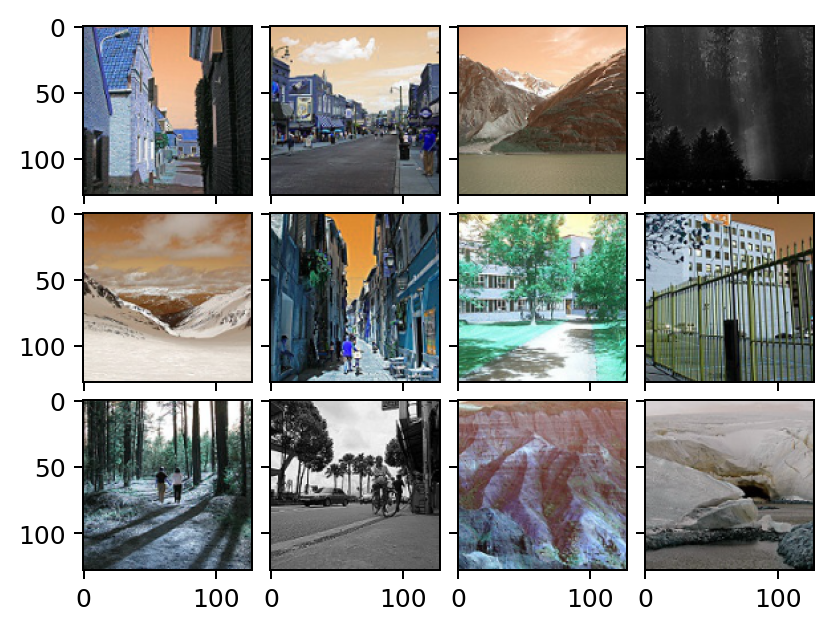

In [10]:
# Display some random images
nrow, ncol = 3, 4
num = nrow * ncol

sample_images = rand.sample(x_tr, num)

fig = plt.figure(dpi=180)
grid = ImageGrid(fig, 111, nrows_ncols=(nrow, ncol), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im)

plt.show()

# 2.) Convert imageset to numpy array and scale

In [5]:
# Convert
np_x_tr = np.array(x_tr)
np_y_tr = np.array(y_tr)

np_x_ts = np.array(x_ts)
np_y_ts = np.array(y_ts)

# Check sanity on shapes
disp.display_markdown(f"Training set shape: {np_x_tr.shape}", raw=True)
disp.display_markdown(f"Testing set shape: {np_x_ts.shape}", raw=True)

disp.display_markdown(f"Training targets shape: {np_y_tr.shape}", raw=True)
disp.display_markdown(f"Testing targets shape: {np_y_ts.shape}", raw=True)

Training set shape: (14034, 128, 128, 3)

Testing set shape: (3000, 128, 128, 3)

Training targets shape: (14034,)

Testing targets shape: (3000,)

### Scale

In [6]:
def scale(imgset):
    domain = [0, 1]